In [1]:
import os
import re
import time
import spotipy
import librosa
import warnings
import requests
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import umap.umap_ as umap
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report


warnings.filterwarnings("ignore")

In [ ]:
# Documentation:
# Client credentials:
#   https://developer.spotify.com/documentation/general/guides/app-settings/#register-your-app
#
# What each audio features means:
#   https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject
#   https://medium.com/@FinchMF/praise-questions-and-critique-spotify-api-38e984a4174b
# LUFS (Loudness):
#   https://www.sweetwater.com/insync/what-is-lufs-and-why-should-i-care/
# Scopes:
#   https://developer.spotify.com/documentation/general/guides/scopes/#user-library-read


# Examples:
#   https://www.researchgate.net/profile/Scott-Wolf/publication/342854806_Just_the_Way_You_Are_Linking_Music_Listening_on_Spotify_and_Personality/links/5f0bc62a92851c52d62f8a3a/Just-the-Way-You-Are-Linking-Music-Listening-on-Spotify-and-Personality.pdf
#   https://www.diva-portal.org/smash/get/diva2:1108465/FULLTEXT02
#   https://ieeexplore.ieee.org/abstract/document/7987199
#   https://www.math.vu.nl/~sbhulai/papers/paper-vandenhoven.pdf
#   https://towardsdatascience.com/discovering-your-music-taste-with-python-and-spotify-api-b51b0d2744d
#   https://towardsdatascience.com/a-music-taste-analysis-using-spotify-api-and-python-e52d186db5fc
#   https://rareloot.medium.com/extracting-spotify-data-on-your-favourite-artist-via-python-d58bc92a4330
#   https://www.kaylinpavlik.com/classifying-songs-genres/
#   https://towardsdatascience.com/using-python-to-refine-your-spotify-recommendations-6dc08bcf408e
#   https://jman4190.medium.com/build-your-own-spotify-wrapped-with-python-spotify-and-glide-apps-493dc7da20b
#   https://musicinformationretrieval.com/index.html

# Cluster
# https://martinfleischmann.net/clustergam-visualisation-of-cluster-analysis/

In [ ]:
# Credentials and access to api
os.environ["SPOTIPY_CLIENT_ID"] = "e93bb9b7b8aa4ba8a817537a0f7696f8"
os.environ["SPOTIPY_CLIENT_SECRET"] = "bd54ecc86e3b4bc08b33f3bed6e89dee"
os.environ['SPOTIPY_REDIRECT_URI'] = "http://localhost:8080"   # Needed for user authorization

In [ ]:
# Get access with user authorization
scope = 'user-library-read user-follow-read'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [ ]:
  # acousticness: 0.0 to 1.0,   1 is acoustic

  # danceability: 0.0 to 1.0,   1 is most danceable

  # energy: 0.0 to 1.0, perceptual measure of intensity and activity. 1.0 energetic tracks feel fast, loud and noisy. 
  #     Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.  
  
  # instrumentalness: 0.0 to 1.0, predicts whether a track contains no vocals (is instrumental).  1.0 is pure intrumental. Above 0.5 represent instrumental tracks.  
  
  # key:  Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.    I still don't understand this :/

  # liveness: 0.0 to 1.0, presence of audience in the recording. 0.8 or above strong likelihood that the track is live.

  # loudness: -60.0 to 0.0db,  Negative number, closer to 0 is louder.

  # mode: 0 or 1, Minor=0 Major=1, Major is happier

  # speechiness: 0.0 to 1.0, detects presence of spoken words. 1.0 is talk show or audio book. 
  #     Values above 0.66 describe tracks that are probably made entirely of spoken words. 
  #     Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. 
  #     Values below 0.33 most likely represent music and other non-speech-like tracks.

  # tempo: BPM, Beats per minute 
  
  # valence: 0.0 to 1.0, describing musical positiveness, the higher the more positive. 
  
  # analysis_url: 
  # duration_ms: 238854,
  # id: '1eT2CjXwFXNx6oY5ydvzKU',
  # time_signature: 4,
  # track_href: 'https://api.spotify.com/v1/tracks/1eT2CjXwFXNx6oY5ydvzKU',
  # type: 'audio_features',
  # uri: 'spotify:track:1eT2CjXwFXNx6oY5ydvzKU',

# Scrap songs from different genres

Spotify has a very good API where you can get access to their song repertoir, however, you cannot access all at once nor do big searches an all 35M+ songs that are available in the platform.

One of the methods used here to collect information about songs for this project is to use the `recommendations()` method from the API. Recommendations are generated based on the available information for a given seed entity and matched against similar artists and tracks. If there is sufficient information about the provided seeds, a list of tracks will be returned together with pool size details.

Using a seed for a specific genre, we started scrapping the server to collect as many songs as possible. With this approach, we garauntee that the songs we are retrieving belong to the genre requested. The genres to analyze here are:

||  |  |
| --- | --- | --- |
| Blues | Classical | Country |
| Electronic | Heavy Metal | Hip Hop |
| Indie | K-pop | Pop |
| Punk | Reggae | Reggaeton |
| Rock | R&B | Salsa |

In [2]:
# Define list of genres to look to build a dataset
genres = ['blues', 'classical', 'country', 'electronic', 'heavy-metal', 'hip-hop', 'indie', 'k-pop', 'pop',
               'punk', 'reggae', 'reggaeton', 'rock', 'r-n-b', 'salsa']

In [ ]:
def get_songs(genres, num_songs):
    """
    Returns a Pandas Data Frame with a set of attributes defined by Spotify for each genre and with the provided 
    number of songs to retrieve
    
    Parameters:
        genres: (list) of genres of those listed by recommendation_genre_seeds() i.e.: ['salsa', 'rock', 'pop']
        num_songs: (int) iterate until retrieving the desired number of songs.
        
    Returns: 
        DataFrame: Pandas df with songs and their atributes for each genre
        .csv file: Files saved after succesfully retrieving songs in increments of 50
    """
    
    song_name = []
    song_id = []
    song_genre = []
    artist = []
    artist_id = []
    artist_genre = []
    release_date = []
    duration_ms = []
    popularity = []
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    duration_ms_ = []
    time_signature = []
    url = []
    
    iterations = 0
    for genre in genres:
        while len(song_id) < num_songs:
            if len(song_id) % 50 == 0: 
                print('iteration: {}, total songs: {}'.format(iterations, len(song_id)))
                df = pd.DataFrame({'song_name':song_name, 'song_id':song_id, 'song_genre':song_genre, 'url':url,
                                   'artist':artist, 'artist_id':artist_id, 'artist_genre':artist_genre, 
                                   'release_date':release_date,'duration_ms':duration_ms, 'popularity':popularity, 
                                   'danceability':danceability, 'energy':energy,'key':key, 'loudness':loudness, 
                                   'mode':mode, 'speechiness':speechiness, 'acousticness':acousticness,
                                   'instrumentalness':instrumentalness, 'liveness':liveness, 'valence':valence, 
                                   'tempo':tempo, 'duration_ms_':duration_ms_, 'time_signature':time_signature})
                df.to_csv('{}.csv'.format(genre))
                
                
                
            songs = sp.recommendations(seed_genres=[genre], limit=100)
            iterations+=1
            for song in songs['tracks']:
                if song['id'] in song_id:
                    pass
                else:
                    song_name.append(song['name'])
                    song_id.append(song['id'])
                    song_genre.append(genre)
                    url.append(song['external_urls']['spotify'])

                    if len(song['artists']) > 1:
                        artists = []
                        artists_ids = [] 
                        artists_genres = []
                        for singer in song['artists']:
                            artists.append(singer['name'])
                            artists_ids.append(singer['id'])
                            artists_genres.append(sp.artist(singer['id'])['genres'])
                        artist.append(artists)
                        artist_id.append(artists_ids)
                        artist_genre.append(artists_genres)
                    else:
                        artist.append(song['artists'][0]['name'])
                        artist_id.append(song['artists'][0]['id'])
                        artist_genre.append(sp.artist(song['artists'][0]['id'])['genres'])

                    release_date.append(song['album']['release_date'])
                    duration_ms.append(song['duration_ms'])
                    popularity.append(song['popularity'])
                    feats = sp.audio_features(song['id'])[0]
                    danceability.append(feats['danceability'])
                    energy.append(feats['energy'])
                    key.append(feats['key'])
                    loudness.append(feats['loudness'])
                    mode.append(feats['mode'])
                    speechiness.append(feats['speechiness'])
                    acousticness.append(feats['acousticness'])
                    instrumentalness.append(feats['instrumentalness'])
                    liveness.append(feats['liveness'])
                    valence.append(feats['valence'])
                    tempo.append(feats['tempo'])
                    duration_ms_.append(feats['duration_ms'])
                    time_signature.append(feats['time_signature'])
            
        print('iteration: {}, total songs: {}'.format(iterations, len(song_id)))
    
    df = pd.DataFrame({'song_name':song_name, 'song_id':song_id, 'song_genre':song_genre, 'url':url,'artist':artist, 
                       'artist_id':artist_id, 'artist_genre':artist_genre, 'release_date':release_date, 
                       'duration_ms':duration_ms, 'popularity':popularity, 'danceability':danceability, 'energy':energy,
                       'key':key, 'loudness':loudness, 'mode':mode, 'speechiness':speechiness, 'acousticness':acousticness,
                       'instrumentalness':instrumentalness, 'liveness':liveness, 'valence':valence, 'tempo':tempo, 
                       'duration_ms_':duration_ms_, 'time_signature':time_signature})
    
    return df 


#### Get data from Spotify, needed to use this method due to constant disconnects from the API
#### Run only if needed, it can take up to 10 hours to run

In [ ]:
# for genre in genres:
#     df = get_songs([genre],1000)
#     df.to_csv('{}_complete.csv'.format(genre))

### Read data into a DataFrame from previously scrapped data

In [3]:
df = pd.read_csv('data/1000_songs.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.sample(3)

,song_name,song_id,song_genre,url,artist,artist_id,artist_genre,release_date,duration_ms,popularity,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms_,time_signature
9857,Dejalo Todo Atras,5GSi3yWwnUo2DGHwTBcfaa,reggaeton,https://open.spotify.com/track/5GSi3yWwnUo2DGH...,J Alvarez,6XFITTl7cFTdopDY3lUdlY,"['latin', 'latin hip hop', 'perreo', 'reggaeto...",2011-09-20,263933,0,...,-5.384,0,0.0430,0.3570,0.000000,0.212,0.814,87.993,263933,4
12720,Cambio de Piel,3AjxOdecZ2eKDL0aOtcYsJ,salsa,https://open.spotify.com/track/3AjxOdecZ2eKDL0...,Marc Anthony,4wLXwxDeWQ8mtUIRPxGiD6,"['latin', 'latin pop', 'modern salsa', 'salsa'...",2013-07-23,279360,60,...,-3.097,1,0.0409,0.5960,0.000004,0.115,0.814,164.127,279360,4
7208,You Know You Like It,57kR5SniQIbsbVoIjjOUDa,pop,https://open.spotify.com/track/57kR5SniQIbsbVo...,"['DJ Snake', 'AlunaGeorge']","['540vIaP2JwjQb9dm3aArA4', '2VAnyOxzJuSAj7XIuE...","[['dance pop', 'edm', 'electronic trap', 'pop'...",2014-10-14,247266,72,...,-5.346,0,0.1880,0.0141,0.000002,0.306,0.247,196.093,247267,4


One aspect to note in this dataset is that the recommendatios seem to be capped at 1000 songs for some genres and to 500 for the lower side with the classical genre. 

In [4]:
for i in genres:
    print("{}: {}".format(i, len(df[df['song_genre']==i]['song_id'].unique())))


blues: 1000
classical: 500
country: 950
electronic: 1000
heavy-metal: 600
hip-hop: 950
indie: 950
k-pop: 650
pop: 950
punk: 850
reggae: 600
reggaeton: 1000
rock: 950
r-n-b: 900
salsa: 1000


### Audio Features
The audio features that we will be exploring are those provided by Spotify for each song.

These features are mostly measured in a scale of 0-1, for example:

- Danceability: a measurement of how "danceable" a given song is.
- Energy: perceptual measure of intensity and activity.
- Intrumentalness: whether a song contains no vocals (pure intrumental).
- Liveness: presence of audience in a song i.e.: on a concert.
- Loudness: How loud a song is in dB.
- Mode: Minor or Major mode.
- Speechiness: presence of words in a song.
- Tempo: Beats per minute (BPM).


In [5]:
feature_names = ['danceability','energy','key','loudness','mode','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo', 'duration_ms','time_signature', 'song_genre']

Crosschecking that the retrieved songs match the genre specified by Spotify. Click on the link to listen to the song.

In [6]:
d = df.sample()[['url', 'song_genre', 'artist_genre']]
print(d['url'][d['url'].index[0]])
print(d['song_genre'])
print(d['artist_genre'])

https://open.spotify.com/track/3eYCJXTViFwl5mdtcTsF4G
684    blues
Name: song_genre, dtype: object
684    [['blues rock', 'classic rock', 'folk rock', '...
Name: artist_genre, dtype: object


# Data Exploration

## Descriptive Statistics

In [7]:
df_feats = df[feature_names]
df_feats.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,12850.000000,12850.000000,12850.000000,12850.000000,12850.000000,12850.000000,12850.000000,12850.000000,12850.000000,12850.000000,12850.000000,1.285000e+04,12850.000000
mean,0.591095,0.678036,5.313930,-7.343142,0.608949,0.091209,0.239980,0.102799,0.191519,0.527995,120.544393,2.435383e+05,3.937510
std,0.177526,0.226651,3.582148,4.514793,0.488005,0.087003,0.289645,0.249886,0.155780,0.256653,30.378698,9.656337e+04,0.352969
min,0.000000,0.000000,0.000000,-43.804000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.056000e+03,0.000000
25%,0.479000,0.545000,2.000000,-8.436500,0.000000,0.038200,0.012525,0.000000,0.092400,0.324000,95.884000,1.981495e+05,4.000000
50%,0.608000,0.720000,6.000000,-6.160500,1.000000,0.054900,0.105000,0.000017,0.129000,0.537000,118.959000,2.276930e+05,4.000000
75%,0.725000,0.856000,8.000000,-4.694000,1.000000,0.104000,0.392750,0.007660,0.254000,0.741750,139.955500,2.686098e+05,4.000000
max,0.976000,1.000000,11.000000,1.342000,1.000000,0.944000,0.996000,0.994000,0.992000,0.991000,220.169000,4.195000e+06,5.000000


## Density plots

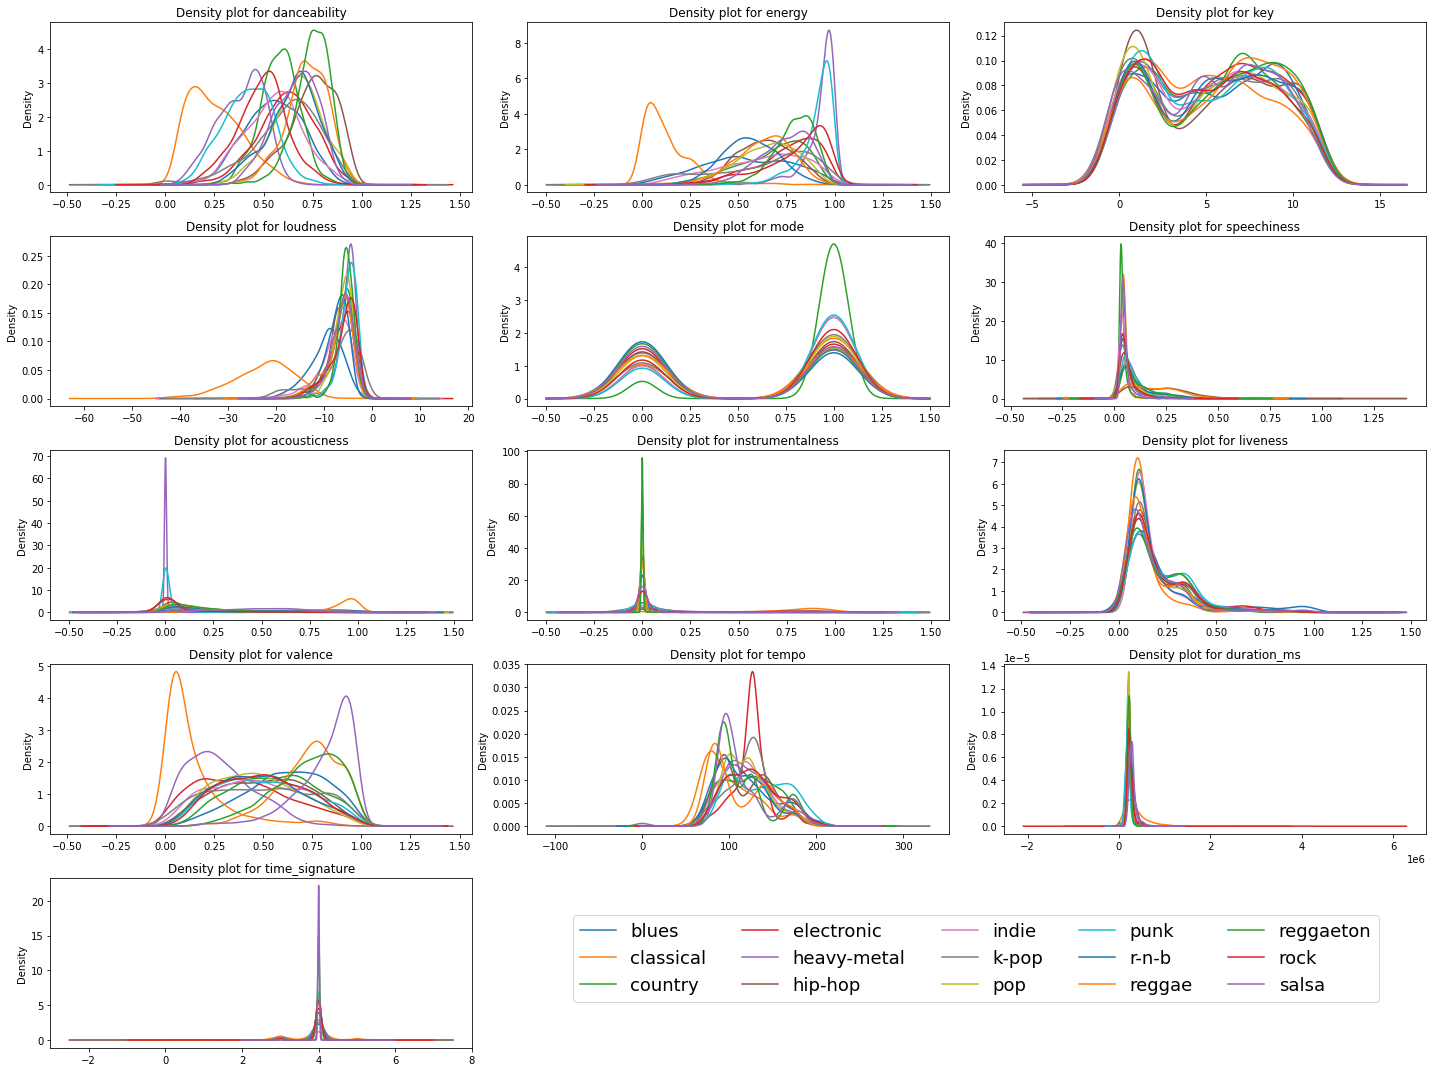

In [8]:
fig = plt.figure(figsize=(20, 15))
for idx,feat in enumerate(feature_names[:-1]):
    ax = fig.add_subplot(5,3,idx+1)
    df_feats.groupby('song_genre')[feat].plot(kind='density', legend=False)
    plt.title('Density plot for {}'.format(feat))

plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=18, bbox_to_anchor=(0.68, 0.06))
plt.show()

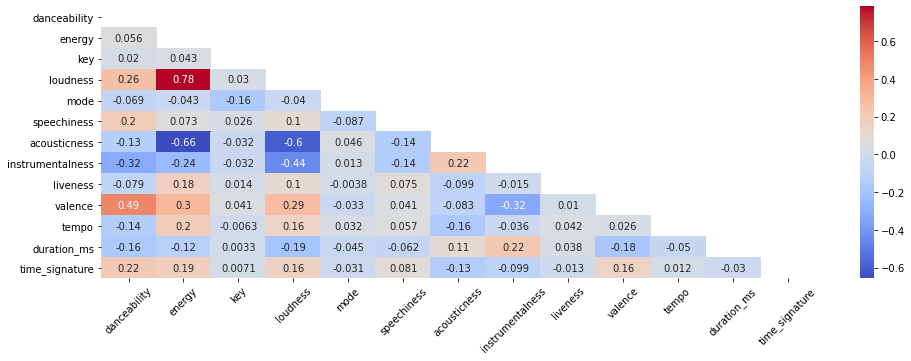

In [9]:
corr = df_feats.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

plt.figure(figsize = (16,5))
ax = sns.heatmap(corr, annot = True, cmap="coolwarm")
plt.xticks(rotation=45)
plt.show()

### Need more features for the classifier, scrap more data from Spotify and use Librosa to analyze the 30 seconds song samples.

In [10]:
## Functions helping to count how many songs are there in the dataframe for each genre and 
## another one to balance data
def song_count(df):
    grouped_df = df.groupby('song_genre').count().reset_index()
    grouped_df
    totals = list(zip(grouped_df['song_genre'], grouped_df[grouped_df.columns[1]]))
    for genre, count in totals:
        print(genre,count)
    print('Total songs: {}'.format(len(df)))

def balance_data(df):
    grouped_df = df.groupby(['song_genre']).count()
    min_songs = min(grouped_df[grouped_df.columns[0]])
    min_genre = grouped_df[grouped_df.columns[0]][grouped_df[grouped_df.columns[0]] == min_songs].index.tolist()
    return df.groupby('song_genre').head(min_songs)
    

In [ ]:
# # Save to .mp3 all 30 second samples
# for idx, url in tqdm(enumerate(df['preview_url'])):
#     doc = requests.get(url)
#     with open('audio/{}_{}_{}.mp3'.format(idx, df.loc[idx]['song_genre'],df.loc[idx]['song_name'].replace('/', '_')), 'wb') as f:
#         f.write(doc.content)

In [ ]:
# def atoi(text):
#     return int(text) if text.isdigit() else text

# def natural_keys(text):
#     '''
#     alist.sort(key=natural_keys) sorts in human order
#     http://nedbatchelder.com/blog/200712/human_sorting.html
#     (See Toothy's implementation in the comments)
#     '''
#     return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [ ]:
# Extract MFCC
# # ## Note: Do not run, unless totally necessary, it will take about 6 hours.
# # ## Add column to the original dataframe to include the link containing the 30 sec song sample

# df['preview_url'] = df['song_id'].apply(lambda row: sp.track(row)['preview_url'])
# df1 = df.dropna().reset_index(drop=True)



# mfcc_feats = []
# for idx, url in tqdm(enumerate(df1['preview_url'])):
#     doc = requests.get(url)
#     with open('current_song.mp3', 'wb') as f:
#         f.write(doc.content)
#     song, sr = librosa.load('current_song.mp3')
#     mfcc = librosa.feature.mfcc(song, sr=sr).T
#     mfcc = mfcc.mean(axis=0).reshape(1,-1)
#     mfcc_feats.append(mfcc)

# df_mfcc = pd.concat([df1, pd.DataFrame(np.concatenate(mfcc_feats))], axis=1)
# df_mfcc.rename(columns={0: 'mfcc_1', 1: 'mfcc_2', 2: 'mfcc_3', 3: 'mfcc_4', 4: 'mfcc_5', 5: 'mfcc_6', 6: 'mfcc_7', 
#                         7: 'mfcc_8', 8: 'mfcc_9', 9: 'mfcc_10', 10: 'mfcc_11', 11: 'mfcc_12', 12: 'mfcc_13', 13: 'mfcc_14', 
#                         14: 'mfcc_15', 15: 'mfcc_16', 16: 'mfcc_17', 17: 'mfcc_18', 18: 'mfcc_19', 19: 'mfcc_20'},
#               inplace=True)
# df_mfcc.to_csv('data/1000_songs_mfcc.csv')

In [ ]:
# # Extract other features from librosa and append to mfcc feats it will take about 4.5 hours to run
# zcr = []
# rolloff = []
# onset = []
# chroma = []
# pitches = []
# magnitudes = []
# spectral_centroid = []
# spectral_flatness = []
# spectral_contrast = []
# poly_features = []
# chroma_cens = []
# songs = []


# for song in tqdm(sorted(os.listdir('audio/'), key=natural_keys)):
#     if song.endswith(".mp3"):    
#         y, sr = librosa.load('audio/{}'.format(song))
#         zcr.append(librosa.feature.zero_crossing_rate(y).mean())
#         rolloff.append(librosa.feature.spectral_rolloff(y).mean())
#         onset.append(librosa.onset.onset_strength(y).mean())
#         chroma.append(librosa.feature.chroma_stft(y).mean())
#         pitch, magnitude = librosa.piptrack(y)
#         pitches.append(pitch.mean())
#         magnitudes.append(magnitude.mean())
#         spectral_centroid.append(librosa.feature.spectral_centroid(y=y, sr=sr).mean())
#         spectral_flatness.append(librosa.feature.spectral_flatness(y=y).mean())
#         S = np.abs(librosa.stft(y))
#         spectral_contrast.append(librosa.feature.spectral_contrast(S=S, sr=sr).mean())
#         poly_features.append(librosa.feature.poly_features(S=S, order=1).mean())
#         chroma_cens.append(librosa.feature.chroma_cens(y=y, sr=sr).mean())
#         songs.append(song)
        
# librosa_feats = pd.DataFrame({'zcr':zcr, 'rolloff':rolloff, 'onset':onset, 'chroma':chroma, 'pitches':pitches, 
#                               'magnitudes':magnitudes, 'spectral_centroid':spectral_centroid, 
#                               'spectral_flatness':spectral_flatness, 'spectral_contrast':spectral_contrast, 
#                               'poly_features':poly_features, 'chroma_cens':chroma_cens})

# df = pd.concat([df, librosa_feats], axis=1)
# df.to_csv('data/1000_songs_mfcc_plus_other_feats.csv')


# Supervised Learning
# Building a classifier to predict a song genre based on song feauteres

In [ ]:
df = pd.read_csv('data/1000_songs_mfcc_plus_other_feats.csv').drop(columns=['Unnamed: 0'])
# dups = pd.read_csv('data/duplicates.csv')['duplicate_idx'].tolist()
# df = df[~df.index.isin(dups)]
df.sample(3)

In [ ]:
# # Generator to show each duplicate
# def Generator(dups):
#     n = 0
#     while n < len(dups):
#         d = df[df['song_id']==dups[n]]
#         idxs = []
#         for row in d:
#             idxs.append(d.index[d['url']==row])
#         yield d.index.tolist()
#         n += 1
# 
# duplicates = df[df.duplicated(['song_id'], keep=False)]['song_id'].unique() # List of duplicates
# 
# myGenerator = Generator(duplicates)

In [ ]:
# Go through generator to play songs and decide which ones to keep/remove
# for row in next(myGenerator):
#     print(df['song_name'][row], df['url'][row], df['song_genre'][row], row)

In [ ]:
# keep_songs = [66, 88, 6054, 6118, 363, 459, 565, 4043, 4404, 4056, 3955, 4176, 1260, 6569, 4768, 6747, 1635, 1664, 
#               1666, 3430, 3344, 1736, 3470, 3327, 1763, 1828, 1871, 3653, 3590, 3258, 3713, 3633, 4743, 3795, 2157, 
#               2196, 2242, 6657, 6807, 2325, 6734, 2379, 2392, 2395, 6951, 2404, 7302, 2418, 2421, 2426, 2427, 6836, 
#               2429, 2430, 2431, 2432, 2438, 2439, 2440, 2442, 2444, 2463, 2465, 2467, 2470, 2480, 2484, 2492, 7058,
#              2498, 2499, 2500, 2505, 2511, 2520, 2524, 2526, 2528, 2530, 2534, 2538, 2540, 2543, 2552, 2556, 2557, 
#              2559, 2564, 2565, 2567, 2571, 2574, 2578, 2582, 2583, 2600, 2601, 2604, 6831, 2620, 2621, 2634, 2636,
#              2640, 2643, 2645, 2647, 2650, 2663, 2667, 2671, 2676, 2685, 2686, 2691, 2692, 2694, 2704, 2707, 2708,
#              2709, 2714, 2717, 2719, 2720, 2725, 2726, 7257, 2733, 2737, 2744, 2751, 2762, 2763, 2764, 2766, 2769, 
#              2777, 2783, 2785, 2787, 2795, 2800, 2802, 2804, 2809, 2810, 6755, 2824, 2829, 2832, 2844, 6844, 2864, 
#              2867, 2869, 2872, 2882, 2885, 2888, 2889, 2891, 2892, 7158, 2898, 2901, 2908, 2909, 2913, 2915, 2926, 
#              2927, 2934, 2940, 2941, 2943, 2944, 2950, 2956, 2971, 2973, 2986, 2988, 2989, 3001, 7416, 4688, 3012,
#              3014, 3015, 3016, 3026, 3038, 3044, 3059, 3078, 3082, 3087, 3094, 3095, 3110, 3112, 3121, 3126, 3131, 
#              3150, 7398, 3154, 4479, 3156, 3157, 3164, 3165, 3189, 3190, 3193, 7580, 3198, 3200, 7463, 3216, 3217,
#              3219, 3244, 7003, 3256, 3264, 7344, 3276, 3305, 3332, 7130, 3373, 3382, 3386, 7049, 3404, 3431, 3435,
#              3461, 3466, 3483, 3487, 7157, 6938, 6358, 6965, 3532, 3542, 3557, 3584, 3591, 3602, 6994, 3613, 3626, 
#              5044, 3641, 3665, 6630, 7372, 3712, 3721, 7177, 3731, 3749, 3753, 7417, 3774, 3780, 6567, 3797, 3836,
#              6631, 6506, 6857, 6941, 6850, 4005, 4008, 4024, 7229, 7289, 6871, 6564, 6907, 7147, 4217, 6899, 7341,
#              7480, 7225, 6915, 6926, 6718, 7175, 7412, 7265, 7101, 7097, 7251, 7258, 4496, 4523, 7356, 7335, 7560,
#              4611, 4614, 4626, 7350, 7322, 7559, 7395, 4742, 4761, 4785, 4814, 6104, 4890, 4892, 4899, 4939, 4942,
#              4946, 4981, 5011, 5080, 5085, 5135, 5151, 5191, 5202, 5432, 7624, 7800, 7639, 7642, 7719, 7721, 7824, 
#              7668, 8116, 5807, 7896, 8028, 5873, 5880, 8123, 5890, 8168, 5948, 8013, 5981, 7808, 6000, 6006]

# duplicates_df = df[df.duplicated(['song_id'], keep=False)]
# idx_to_remove = duplicates_df[~duplicates_df.index.isin(keep_songs)].index.tolist()
# pd.DataFrame(idx_to_remove, columns =['duplicate_idx']).to_csv('data/duplicates.csv', index=False)

In [ ]:
# Checking song counts after processing new features and dropping rows without mfcc features
song_count(df)

In [ ]:
# Original Features
feature_names_mfcc = ['danceability','energy','key','loudness','mode','speechiness','acousticness',
                      'instrumentalness','liveness','valence','tempo', 'duration_ms','time_signature', 
                      'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
                      'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 
                      'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'zcr', 'rolloff', 'onset', 'chroma',
                      'pitches', 'magnitudes','song_genre']

In [ ]:
# All Features
feature_names_mfcc = ['danceability','energy','key','loudness','mode','speechiness','acousticness',
                      'instrumentalness','liveness','valence','tempo', 'duration_ms','time_signature', 
                      'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
                      'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 
                      'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'zcr', 'rolloff', 'onset', 'chroma',
                      'pitches', 'magnitudes', 'spectral_centroid', 'spectral_flatness', 'spectral_contrast',
                      'poly_features', 'chroma_cens', 'song_genre']

In [ ]:
# Cherry Pick Features
feature_names_mfcc = ['danceability','energy','loudness','speechiness','acousticness',
                      'instrumentalness','liveness','valence','tempo', 'duration_ms', 
                      'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
                      'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 
                      'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'zcr', 'rolloff', 'onset', 'chroma',
                      'pitches', 'magnitudes', 'spectral_centroid', 'spectral_flatness', 'spectral_contrast',
                      'poly_features', 'chroma_cens', 'song_genre']

In [ ]:
To remove:
    time_signature, key, mode, 
Maybe to remove: 
    acousticness, instrumentalness
From librosa:
    spectral: centroid, flatness, contrast Maybe poly features, chroma sens

In [ ]:
# Split data in training and test sets
df_data = df[feature_names_mfcc]
#Removing KPop due to very little information
df_data = df_data[df_data['song_genre'] != 'k-pop']
# df_data = balance_data(df_data)
X = df_data.iloc[:, :-1]
y = df_data.iloc[:, -1]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

In [ ]:
# Dummy classifiers to check against real classifier
dummy_A = DummyClassifier(strategy = 'stratified', random_state = 0).fit(X_train, y_train)
dummy_B = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)

y_dummy_A_predictions = dummy_A.predict(X_test)
y_dummy_B_predictions = dummy_B.predict(X_test)

preA = precision_score(y_test, y_dummy_A_predictions, average='micro')
recA = recall_score(y_test, y_dummy_A_predictions, average='micro')
accA = accuracy_score(y_test, y_dummy_A_predictions)

preB = precision_score(y_test, y_dummy_B_predictions, average='micro')
recB = recall_score(y_test, y_dummy_B_predictions, average='micro')
accB = accuracy_score(y_test, y_dummy_B_predictions)

Very low scores for the dummy classifiers

In [ ]:
preA, recA, accA, preB, recB, accB

In [ ]:
clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average='micro')
pre = precision_score(y_test, y_pred, average='micro')

acc, rec, pre, clf.score(X_test,y_test)

In [ ]:
models = [('GaussianNB', GaussianNB()), ('RandomForest', RandomForestClassifier()), ('KNN', KNeighborsClassifier()), 
          ('SVM', SVC(probability=True)), ('GradientBoosting', GradientBoostingClassifier()), ('XGB', XGBClassifier(eval_metric='mlogloss'))]
dfs = []
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted']
target_names = y.unique().tolist()

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    cv_results = model_selection.cross_validate(model, X_train, y_train.values, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

In [ ]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

In [ ]:
feature_names_mfcc = ['danceability','energy','loudness','speechiness','acousticness',
                      'instrumentalness','liveness','valence','tempo', 'duration_ms', 
                      'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
                      'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 
                      'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'zcr', 'rolloff', 'onset', 'chroma',
                      'pitches', 'magnitudes','song_genre']